In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

In [59]:
device_id = 1
device_name = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(device_name)
print('Using {} device'.format(DEVICE))

Using cuda:1 device


In [1]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seed(2)

NameError: name 'np' is not defined

In [60]:
class Drift(nn.Module):
    def __init__(self, input_dim):
        super(Drift, self).__init__()
        self.embedder = torch.nn.Sequential(
            torch.nn.Linear(input_dim+1, 2000),
            torch.nn.ReLU(),
            torch.nn.Linear(2000, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, input_dim)
        )
    
    def forward(self, x_t, t):
        if isinstance(t, (int, float)):
            n = x_t.size(0)
            T = t*torch.ones((n, 1)).float().to(DEVICE)
            X = torch.cat((x_t, T), dim=1)
        elif isinstance(t, torch.Tensor):
            X = torch.cat((x_t, t), dim=1)
        return self.embedder(X)

class drift_gaussian_gaussian(nn.Module):
    def __init__(self, mu0, mu1, sigma2_0, sigma2_1):
        super(drift_gaussian_gaussian, self).__init__()
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma2_0 = sigma2_0
        self.sigma2_1 = sigma2_1

    def score(self, x_t, t):
        sigma2_t = self.sigma2_1*t*t + self.sigma2_0*(1-t)*(1-t)
        mu_t = self.mu1*t + self.mu0*(1-t)
        s_t = (t*mu_t - x_t)/sigma2_t

        return s_t
    
    def forward(self, x_t, t):
        if t==1.0:
            return x_t - self.mu0
        elif t==0.0:
            return self.mu1 - x_t
        else:
            v_t = x_t/t + ((1-t)/t)*self.score(x_t, t)
            return v_t
        
class CustomDataset(Dataset):
    def __init__(self, X, Z):
        self.X = X
        self.Z = Z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Z[idx]

In [120]:
# Training loop

def train(model, num_epochs, dataloader, save_loss):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch in dataloader:
            x, z = batch
            m, d = z.size(0), z.size(1)

            # perm = torch.randperm(m)
            # x = x[perm, :].to(DEVICE).float()
            # z = z[perm, :].to(DEVICE).float()
            
            x = x.to(DEVICE).float()
            z = z.to(DEVICE).float() 

            x = x.unsqueeze(0).repeat(m, 1, 1).reshape(-1, d)
            z = z.unsqueeze(1).repeat(1, m, 1).reshape(-1, d)

            t = torch.from_numpy(np.random.uniform(0, 1, z.size(0))).to(DEVICE).float().view(-1, 1)
            x_t = t*x + (1-t)*z

            # Zero the parameter gradients
            model_optimizer.zero_grad()

            # Compute loss
            loss = criterion(model(x_t, t), (x-z))

            # Backward pass and optimize
            loss.backward()
            model_optimizer.step()
            
            # Accumulate loss
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate and print average loss for the epoch
        avg_loss = epoch_loss / num_batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

        # Step the scheduler with the average loss
        scheduler.step(avg_loss)

        save_loss.append(avg_loss)
    
    return save_loss


def plot_loss(save_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(save_loss, marker='o', linestyle='-', color='b')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    plt.close()
    return

In [124]:
def sample(model, T, num_samples, input_dim):
    Z_0_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

    Z_0 = torch.from_numpy(Z_0_np).to(DEVICE).float()

    with torch.no_grad():
        trajectory = Z_0.unsqueeze(0).repeat(T+1, 1, 1)
        ones = torch.ones((num_samples, 1)).float().to(DEVICE)
        drift_save = model(trajectory[0, :, :], 0*ones).repeat(T+1, 1, 1)

        for i in range(1, T+1):
            t_i_minus_1 = ones*(i-1)/T
            trajectory[i, :, :] = trajectory[i-1, :, :] + model(trajectory[i-1, :, :], t_i_minus_1)/T
            drift_save[i, :, :] = model(trajectory[i-1, :, :], t_i_minus_1)
    return trajectory, drift_save

def plot_trajectories(trajectory, plot_paths=True):
    trajectory_np = trajectory.cpu().numpy()
    (T, n, d) = trajectory.shape
    if plot_paths:
        for i in range(n):
            particle_trajectory = trajectory_np[:, i, :]
            plt.plot(particle_trajectory[:, 0], particle_trajectory[:, 1], alpha=0.1, color="purple")
            
    plt.scatter(trajectory_np[T-1, :, 0], trajectory_np[T-1, :, 1], label="End points", color="green")
    plt.scatter(trajectory_np[0, :, 0], trajectory_np[0, :, 1], label="Initial points", color="orange")
    plt.scatter(X_np[:, 0], X_np[:, 1], label="Original data points", color="blue", alpha=0.05)
    
    plt.title('Trajectories of particles over time, T={}'.format(T-1))
    plt.legend()
    plt.show()
    plt.close()
    return

In [125]:
input_dim = 2
num_samples = 5000

Z_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

mean1 = [5, 9]
cov1 = [[1, 0], [0, 1]]

# mean2 = [8, 3]
# cov2 = [[1, -0.5], [-0.5, 1]]

# Mixing proportions
weights = [1, 0]

# Determine the number of samples from each component
num_samples_component = np.random.multinomial(num_samples, weights)

# Generate the samples
X_np = np.vstack([
    np.random.multivariate_normal(mean1, cov1, num_samples_component[0])
])
np.random.shuffle(X_np)


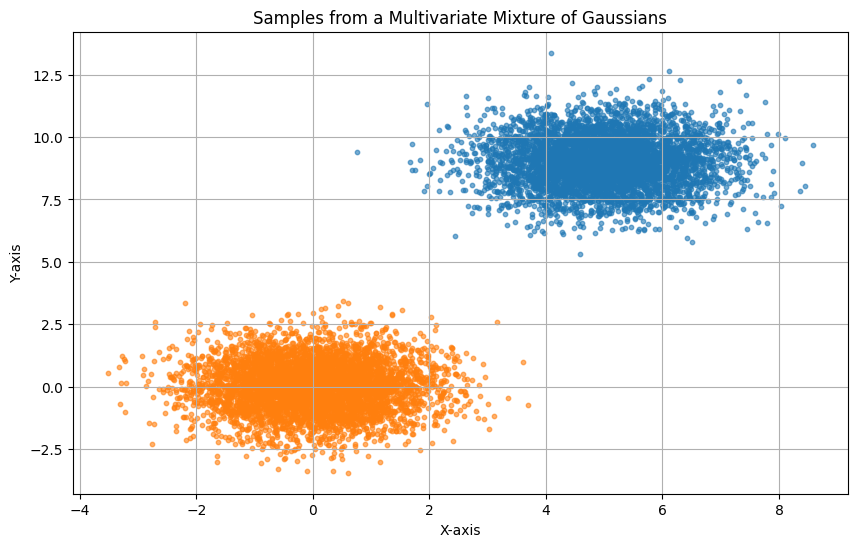

In [126]:
# Plot the samples
plt.figure(figsize=(10, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], s=10, alpha=0.6)
plt.scatter(Z_np[:, 0], Z_np[:, 1],  s=10, alpha=0.6)
plt.title('Samples from a Multivariate Mixture of Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [127]:
X = torch.from_numpy(X_np)
Z = torch.from_numpy(Z_np)

# Create an instance of the custom dataset
dataset = CustomDataset(X, Z)

# Create a DataLoader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [128]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

model = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model.parameters(), lr=0.01)
save_loss = []
num_epochs = 50
scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

/home/vbansal/.conda/envs/ibc/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [129]:
save_loss = train(model, num_epochs, dataloader, save_loss)

Epoch [1/50], Average Loss: 38226.1804
Epoch [2/50], Average Loss: 19.3670
Epoch [3/50], Average Loss: 7.5888
Epoch [4/50], Average Loss: 3.8815
Epoch [5/50], Average Loss: 2.4497
Epoch [6/50], Average Loss: 2.1425
Epoch [7/50], Average Loss: 2.0714
Epoch [8/50], Average Loss: 2.0276
Epoch [9/50], Average Loss: 1.9630
Epoch [10/50], Average Loss: 1.9198
Epoch [11/50], Average Loss: 1.9325
Epoch [12/50], Average Loss: 2.0596
Epoch [13/50], Average Loss: 1.9633
Epoch [14/50], Average Loss: 1.8500
Epoch [15/50], Average Loss: 1.8190
Epoch [16/50], Average Loss: 1.7958
Epoch [17/50], Average Loss: 1.7894
Epoch [18/50], Average Loss: 1.8156
Epoch [19/50], Average Loss: 1.8430
Epoch [20/50], Average Loss: 1.8985
Epoch [21/50], Average Loss: 1.8618
Epoch [22/50], Average Loss: 1.7824
Epoch [23/50], Average Loss: 1.7299
Epoch [24/50], Average Loss: 1.7344
Epoch [25/50], Average Loss: 1.7375
Epoch [26/50], Average Loss: 1.7379
Epoch [27/50], Average Loss: 1.8040
Epoch [28/50], Average Loss: 2.0

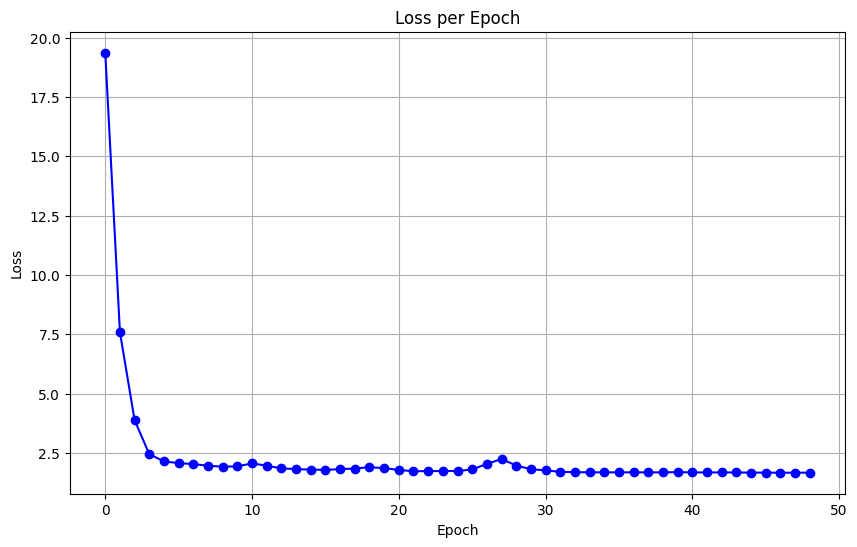

In [130]:
plot_loss(save_loss[1:])

In [138]:
# T euler steps
mu1 = torch.tensor(mean1).float().to(DEVICE)
mu0 = torch.tensor([0, 0]).float().to(DEVICE)

true_drift = drift_gaussian_gaussian(mu0, mu1, 1, 1)
T = 2000
num_samples = 2000
trajectory, save_drift = sample(model, T, num_samples, 2)

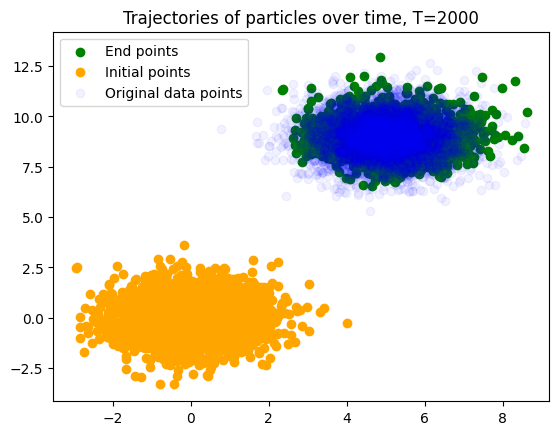

In [139]:
plot_trajectories(trajectory, plot_paths=False)

In [18]:
X_1, Z_1 = trajectory[T, :, :], trajectory[0, :, :]

dataset_1 = CustomDataset(X_1, Z_1)
dataloader_1 = DataLoader(dataset_1, batch_size=batch_size, shuffle=True)

model_1 = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model_1.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

In [19]:
save_loss = train(model_1, num_epochs, dataloader_1)

Epoch [1/30], Average Loss: 108030.1275
Epoch [2/30], Average Loss: 9.8523
Epoch [3/30], Average Loss: 5.4815
Epoch [4/30], Average Loss: 2.8856
Epoch [5/30], Average Loss: 2.2885
Epoch [6/30], Average Loss: 2.2147
Epoch [7/30], Average Loss: 2.0689
Epoch [8/30], Average Loss: 2.0670
Epoch [9/30], Average Loss: 2.0133
Epoch [10/30], Average Loss: 2.0160
Epoch [11/30], Average Loss: 1.9832
Epoch [12/30], Average Loss: 1.9904
Epoch [13/30], Average Loss: 1.8938
Epoch [14/30], Average Loss: 1.8668
Epoch [15/30], Average Loss: 1.9715
Epoch [16/30], Average Loss: 1.9231
Epoch [17/30], Average Loss: 1.8991
Epoch [18/30], Average Loss: 1.8251
Epoch [19/30], Average Loss: 1.8655
Epoch [20/30], Average Loss: 1.8238
Epoch [21/30], Average Loss: 1.8292
Epoch [22/30], Average Loss: 1.7746
Epoch [23/30], Average Loss: 1.7667
Epoch [24/30], Average Loss: 1.7658
Epoch [25/30], Average Loss: 1.7876
Epoch [26/30], Average Loss: 1.7432
Epoch [27/30], Average Loss: 1.8697
Epoch [28/30], Average Loss: 1.7

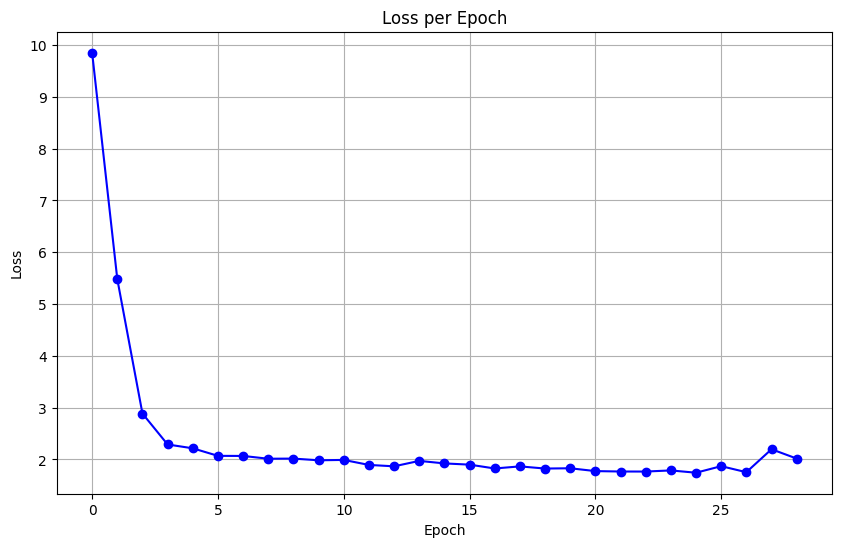

In [20]:
plot_loss(save_loss[1:])

In [23]:
T = 1000
trajectory_1, save_drift_1 = sample(model_1, T, num_samples)

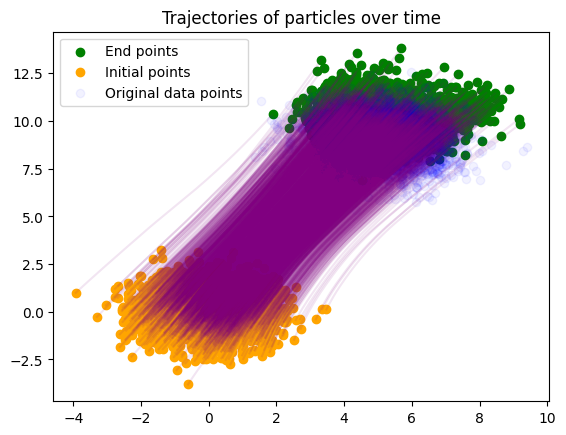

In [24]:
plot_trajectories(trajectory_1, plot_paths=True)